In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pathlib 
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

import PT_files.save_load as sl
from DnCNN_NP.layers  import relu, np_Conv2d, np_BatchNorm2d

import time 
from collections import OrderedDict
import pdb

- They take inspiration from Andrej Karpathy's `im2col.py` file which can be found in these [slides here](http://cs231n.stanford.edu/slides/2016/winter1516_lecture11.pdf). 

- An article that I believe talks about the speed of `im2col.py` is [linked here](https://petewarden.com/2015/04/20/why-gemm-is-at-the-heart-of-deep-learning/). Need to read.

- Lastly, there's a nice package that implements convolutions in a slow (ie. nested for loops) and a fast way (ie. uses im2col idea). Seems like it's fast? That's linked [here](https://github.com/3outeille/CNNumpy/blob/master/src/slow/layers.py)
    - [Blog post](https://hackmd.io/@machine-learning/blog-post-cnnumpy-slow) discussing the `slow` version 
    - [Blog post](https://hackmd.io/@machine-learning/blog-post-cnnumpy-fast) discussing the `fast` version that uses im2col
    
**NOTE:** If the PyTorch model isn't set to device ie. `model.to(device)` isn't set the code will differ between the `NumPy` and the `PyTorch` code, which is interesting.

**NOTE:** Make sure that `model.eval()` mode when doing inference with `nn.BatchNorm2d`

# **0. Testing first layer of model in Pytorch & Numpy == SAME**

In [2]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
name = '2k_model_bs64_e800_ps50_Adam.pth'

# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

Shape of test set= (108, 1, 6000, 6000)


In [3]:
samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

# 1st Layer
conv_out = np_Conv2d(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
out = relu(conv_out)

Conv takes 0.6377418839838356 seconds


In [4]:
test_sample = samp
test_sample = torch.as_tensor(test_sample)
test_sample = test_sample.to(device)
# sample_torch = torch.from_numpy(sample)
params = OrderedDict({'0.weight': weights['layers.0.0.weight'], '0.bias': weights['layers.0.0.bias']})


model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same'),
                      nn.ReLU(inplace=True))

model.to(device)
model.load_state_dict(params)
pytorch_conv_out = model(test_sample)
pytorch_conv_out = pytorch_conv_out.detach().cpu().numpy()

print(np.allclose(out, pytorch_conv_out))

True


# **1. Testing first 2 layers of model in Pytorch & Numpy**

In [5]:
def np_BatchNorm2d(x, weights_dict, prefix, epsilon=1e-5):
    
    batch_start = time.perf_counter()

    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1).reshape(-1, 1, 1)
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
    
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    
    batch_end = time.perf_counter()
    print('Batch takes', batch_end-batch_start, 'seconds')
    
    return output

In [6]:
samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

# 1st Layer
conv_out = np_Conv2d(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
out = relu(conv_out)

# Second Layer
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.1.0.')
# batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.1.1.')
# out = relu(batch_out)

Conv takes 0.590339454007335 seconds
Conv takes 18.449781183036976 seconds


In [7]:
test_sample = samp
test_sample = torch.as_tensor(test_sample)
test_sample = test_sample.to(device)
# sample_torch = torch.from_numpy(sample)
# params = OrderedDict({'weight': weights['layers.0.0.weight'], 'bias': weights['layers.0.0.bias']})
params = OrderedDict({'0.weight': weights['layers.0.0.weight'], '0.bias': weights['layers.0.0.bias'], 
                      '2.weight': weights['layers.1.0.weight'], '2.bias': weights['layers.1.0.bias']})#,
                     #  '3.weight': weights['layers.1.1.weight'], '3.bias': weights['layers.1.1.weight'],
                     #  '3.running_mean': weights['layers.1.1.running_mean'], '3.running_var': weights['layers.1.1.running_var'],
                     # '3.num_batches_tracked': weights['layers.1.1.num_batches_tracked']})

# model = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same') # 1 input channel, 1 output channels, kernelsize=3, stride=1, padding=0
model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(inplace=True),
                     nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))#,
                      # nn.BatchNorm2d(num_features=64),
                      #                   nn.ReLU(inplace=True))#,
                      # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))

# params = model.state_dict()
# print(params.keys())
model.to(device)
model.load_state_dict(params)
pytorch_conv_out = model(test_sample)
pytorch_conv_out = pytorch_conv_out.detach().cpu().numpy()

print(np.allclose(conv_out, pytorch_conv_out))

False


In [10]:
pytorch_conv_out.shape

(1, 64, 2000, 2000)

In [11]:
conv_out.shape

(1, 64, 2000, 2000)

In [8]:
print(pytorch_conv_out[0][0][0][:10])
print(conv_out[0][0][0][:10])

[-0.03993676 -0.79065734 -0.5712429  -0.5504655  -0.5256261  -0.49838743
 -0.46664798 -0.46257123 -0.438536   -0.44341552]
[-0.04011539 -0.7907754  -0.5710279  -0.5507196  -0.52562034 -0.4982569
 -0.46658584 -0.46274468 -0.4386391  -0.44338843]


In [9]:
print(pytorch_conv_out.shape)
print(pytorch_conv_out[0][0][0][:10])

(1, 64, 2000, 2000)
[2.4256632 0.5664626 1.1098543 1.1613108 1.222827  1.290285  1.3688896
 1.3789858 1.4385104 1.4264259]


## **1.1 Testing BatchNorm's**

In [10]:
model = nn.BatchNorm2d(num_features=1)
params = model.state_dict()

model.to(device)
model.load_state_dict(params)
pytorch_batch_out = model(test_sample)
pytorch_batch_out = pytorch_batch_out.detach().cpu().numpy()

# **2.Testing Whole Model**

In [5]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
name = '2k_model_bs64_e800_ps50_Adam.pth'

# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

Shape of test set= (108, 1, 6000, 6000)


In [6]:
def np_BatchNorm2d(x, weights_dict, prefix, epsilon=1e-5):
    
    batch_start = time.perf_counter()

    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1).reshape(-1, 1, 1)
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
    
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    
    batch_end = time.perf_counter()
    print('Batch takes', batch_end-batch_start, 'seconds')
    
    return output

In [8]:
# DnCNN Model

# 1st layer block
conv_out = np_Conv2d(input_data=samp, weights_dict=weights, prefix='layers.0.0.')
out = relu(conv_out)
print(1)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.1.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.1.1.')
out = relu(batch_out)
print(2)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.2.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.2.1.')
out = relu(batch_out)
print(3)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.3.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.3.1.')
out = relu(batch_out)
print(4)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.4.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.4.1.')
out = relu(batch_out)
print(5)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.5.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.5.1.')
out = relu(batch_out)
print(6)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.6.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.6.1.')
out = relu(batch_out)
print(7)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.7.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.7.1.')
out = relu(batch_out)
print(8)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.8.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.8.1.')
out = relu(batch_out)
print(9)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.9.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.9.1.')
out = relu(batch_out)
print(10)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.10.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.10.1.')
out = relu(batch_out)
print(11)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.11.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.11.1.')
out = relu(batch_out)
print(12)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.12.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.12.1.')
out = relu(batch_out)
print(13)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.13.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.13.1.')
out = relu(batch_out)
print(14)


# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.14.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.14.1.')
out = relu(batch_out)
print(15)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.15.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.15.1.')
out = relu(batch_out)
print(16)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.16.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.16.1.')
out = relu(batch_out)
print(17)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.17.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.17.1.')
out = relu(batch_out)
print(18)

# 2nd layer block
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.18.0.')
batch_out = np_BatchNorm2d(x=conv_out, weights_dict=weights, prefix='layers.18.1.')
out = relu(batch_out)
print(19)

# Last layer
conv_out = np_Conv2d(input_data=out, weights_dict=weights, prefix='layers.19.')
print(20)

resid_img = samp - conv_out

Conv takes 0.5533250239677727 seconds
1
Conv takes 18.697666908963583 seconds
Batch takes 0.5045526780886576 seconds
2
Conv takes 17.90644751198124 seconds
Batch takes 0.5009071540553123 seconds
3
Conv takes 17.692831719992682 seconds
Batch takes 0.49337130796629936 seconds
4
Conv takes 17.658960210043006 seconds
Batch takes 0.4989457989577204 seconds
5
Conv takes 17.701320921070874 seconds
Batch takes 0.4945076289586723 seconds
6
Conv takes 17.72293636808172 seconds
Batch takes 0.4936418810393661 seconds
7
Conv takes 17.687580841011368 seconds
Batch takes 0.4970894700381905 seconds
8
Conv takes 17.76647772907745 seconds
Batch takes 0.496795033919625 seconds
9
Conv takes 17.863915389985777 seconds
Batch takes 0.49420221894979477 seconds
10
Conv takes 17.87153451703489 seconds
Batch takes 0.49953657400328666 seconds
11
Conv takes 17.93573930801358 seconds
Batch takes 0.4963953970000148 seconds
12
Conv takes 17.855789258959703 seconds
Batch takes 0.4949578170198947 seconds
13
Conv takes 

Text(0.5, 1.0, 'Numpy Denoised Image')

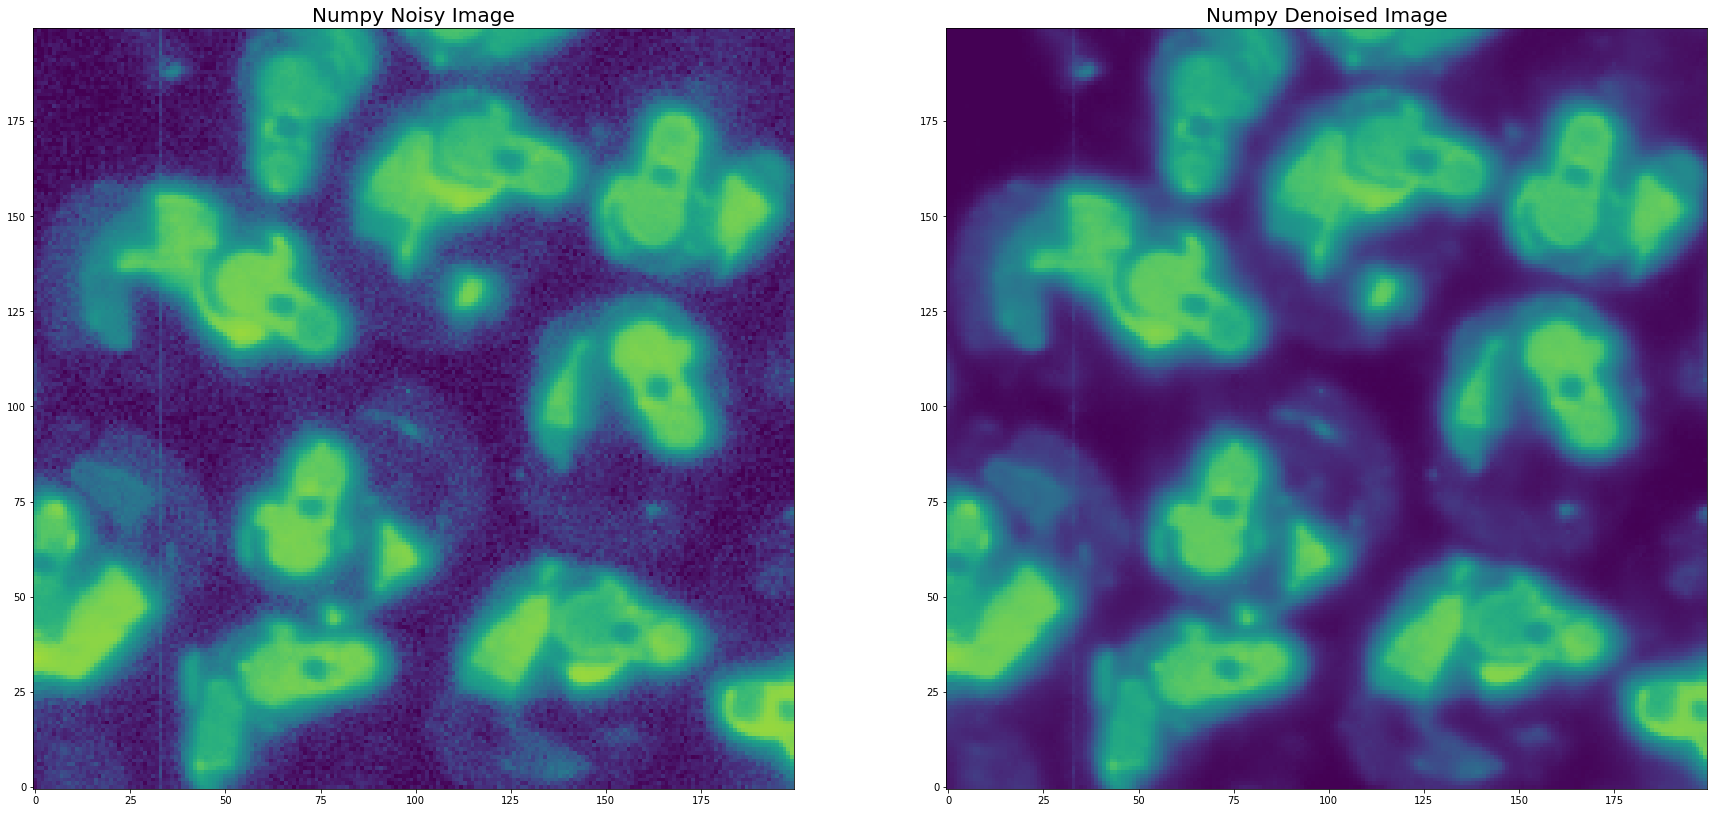

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(30, 26))
vmin, vmax = np.percentile(samp[0][0], (1,99))

# axes[0].imshow(samp[0][0], vmin=vmin, vmax=vmax, origin='lower')
# axes[0].set_title('Input Noisy Image', fontsize=20)
# axes[1].imshow(resid_img[0][0],vmin=vmin, vmax=vmax, origin='lower')
# axes[1].set_title('Numpy Denoised Image', fontsize=20)
axes[0].imshow(samp[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[0].set_title('Numpy Noisy Image', fontsize=20)
axes[1].imshow(resid_img[0][0][1000:1200,1000:1200], vmin=vmin, vmax=vmax,origin='lower')
axes[1].set_title('Numpy Denoised Image', fontsize=20)

In [10]:
def grid_window(dataset,
                model,
                model_params,
                samp_idx,
                h_start,
                h_end,
                w_start,
                w_end):
    
    """
    Function to calculate a specified sized inference window.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    h_start: int
        The height starting index of the inference window.
        E.g. It would be the origin for the y-coord in a 2-D plot
    h_end: int
        The height ending index of the inference window.
        E.g. It would be the end of the y-axis for the y-coord 
        in a 2-D plot
    w_start: int
        The horizontal starting index of the inference window.
        E.g. It would be the origin for the x-coord in a 2-D plot
    w_end: int
        The horizontal ending index of the inference window.
        E.g. It would be the end of the x-axis for the x-coord 
        in a 2-D plot
   
        
    Returns:
    --------
    full: np.array
        Array of the models output over the window region.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))
    
    noise_data = dataset[0]
    params_name = model_params
    
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / params_name
    print('Check pt 1')
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval()
    print('Check pt 2')

    
    with torch.no_grad():
                
        torch.cuda.empty_cache()
        test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1, :, h_start:h_end, w_start:w_end])
        test_noise = test_noise.to(device)
        print('Check pt 3')

        
        output = model(test_noise)
        resid_img = output.detach().cpu().numpy()
        print('Check pt 4')
        
        test_noise.detach().cpu()
        torch.cuda.empty_cache()
        del test_noise
        
        full[:, :, h_start:h_end, w_start:w_end] += resid_img
        count[:, :, h_start:h_end, w_start:w_end] += 1
        
        torch.cuda.empty_cache()
        del resid_img
        print('Run finished')
        
        
    return full, count

In [11]:
from PT_files.model import DnCNN

full_c1, count_c1 = grid_window(dataset=test_data,
                                        model=DnCNN,
                                        model_params="2k_model_bs64_e800_ps50_Adam.pth",
                                        samp_idx=0,
                                        h_start=1000,
                                        h_end=3000,
                                        w_start=1000,
                                        w_end=3000)

Using cuda device
Check pt 1
Check pt 2
Check pt 3
Check pt 4
Run finished


In [18]:
pytorch = full_c1[0][0][1000:3000, 1000:3000]
pytorch_out = np.reshape(pytorch, (1, 1, 2000, 2000))

true_sample = test_data[1]
true_samp = true_sample[0][0][1000:3000, 1000:3000]
true_samp = true_samp.reshape((1, 1, 2000, 2000))

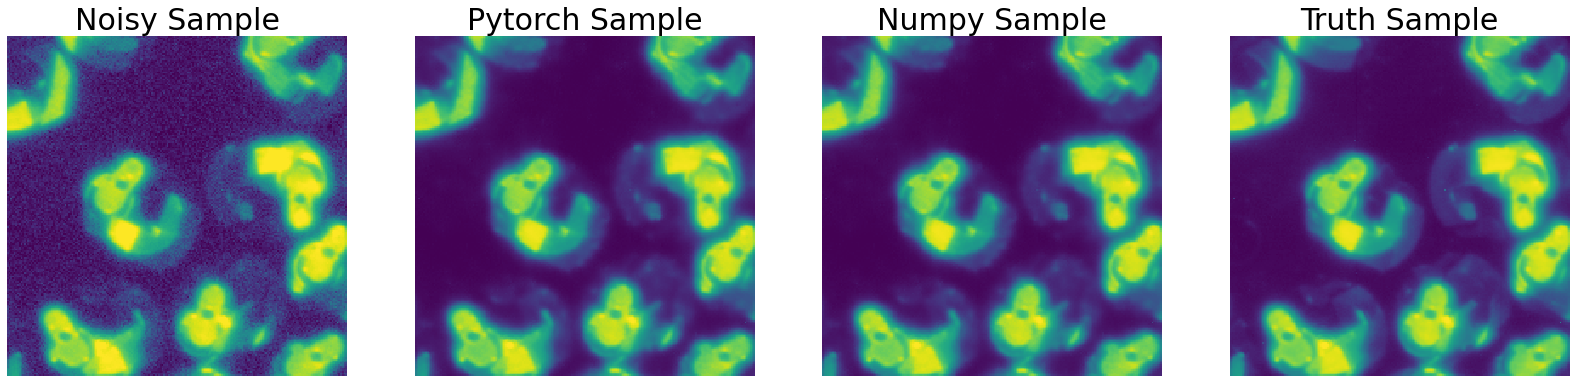

In [30]:
def pytorch_numpy_comparison(raw_noise,
                             raw_clean,
                             pytorch_inf,
                             numpy_inf,
                             size,
                             start_idx,
                             end_idx):
    
    # data_6k = raw_data
    full_img_inf = pytorch_inf
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 4, figsize=(28,24))
    vmin, vmax = np.percentile(raw_noise[0][0][start_idx:end_idx,start_idx:end_idx], (1,99))


    ax[0].imshow(raw_noise[0][0][start_idx:end_idx,start_idx:end_idx], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Sample', fontsize=30)
    ax[1].imshow(full_img_inf[0][0][start_idx:end_idx,start_idx:end_idx],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Pytorch Sample', fontsize=30)
    ax[2].imshow(numpy_inf[0][0][start_idx:end_idx,start_idx:end_idx],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Numpy Sample', fontsize=30)
    ax[3].imshow(raw_clean[0][0][start_idx:end_idx,start_idx:end_idx], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Truth Sample', fontsize=30)
    
pytorch_numpy_comparison(raw_noise=samp,
                         raw_clean=true_samp,
                         pytorch_inf=pytorch_out,
                         numpy_inf=resid_img,
                         size=200,
                         start_idx=1400,
                         end_idx=1600)

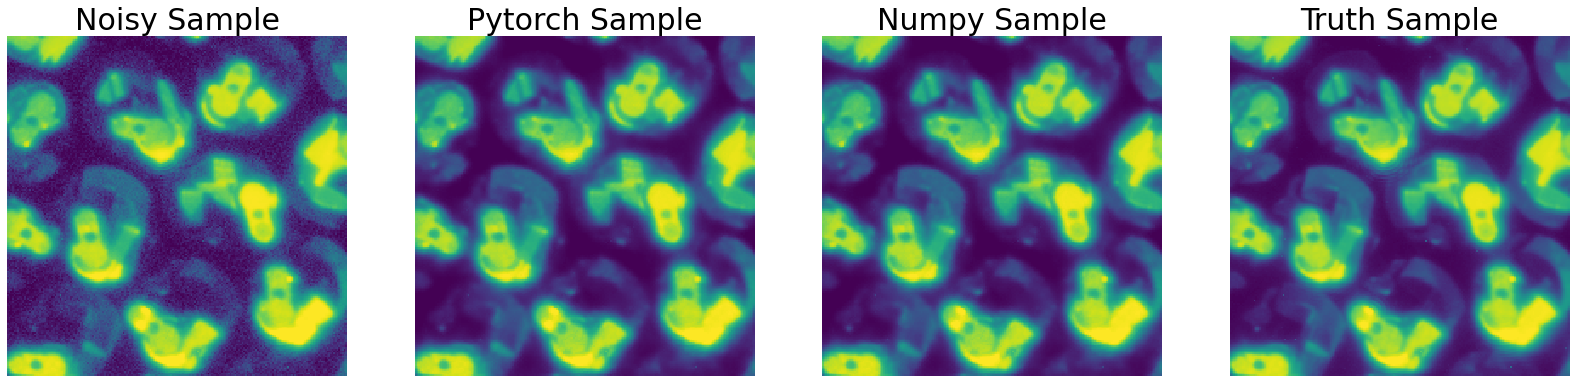

In [31]:
pytorch_numpy_comparison(raw_noise=samp,
                         raw_clean=true_samp,
                         pytorch_inf=pytorch_out,
                         numpy_inf=resid_img,
                         size=200,
                         start_idx=400,
                         end_idx=600)

In [32]:
np.allclose(pytorch_out[1000:3000, 1000:3000], resid_img)

True